# Constructing our Minimum-Covariance Portfolios

We will be constructing our portfolios by selecting the assets which have the lowest correlations between each other. We will rebalance semi-annually based on these selections, and at each rebalance, ensure that our portfolio is split among the two geographies 50/50 

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Preprocessing

In [121]:
# Remove 1st line since they are pct changes, therefore have
# NaNs in the first row
rets = pd.read_csv("data/returns.csv")[1:]

# Reindex to date
rets.index = pd.to_datetime(rets['Date'])
del rets['Date']

rets.head()

USA_EWJ   USA_EWT  USA_MCHI   USA_EWY   USA_EWZ  USA_INDA  \
Date                                                                     
2011-01-04  0.000804 -0.007407       NaN  0.002263  0.004396       NaN   
2011-01-05 -0.007231 -0.016584       NaN  0.000376 -0.011616       NaN   
2011-01-06  0.000000 -0.002108       NaN -0.006960 -0.010049       NaN   
2011-01-07  0.003777 -0.015632       NaN  0.005493 -0.009119       NaN   
2011-01-10  0.000000  0.002146       NaN -0.014883 -0.010071       NaN   

            USA_ACWV   USA_IDV   USA_EWC   USA_EWU  ...  CAN_HULC.TO  \
Date                                                ...                
2011-01-04       NaN -0.009259 -0.010412  0.010462  ...          NaN   
2011-01-05       NaN -0.002596  0.002023 -0.002157  ...          NaN   
2011-01-06       NaN -0.009891 -0.004847 -0.008647  ...          NaN   
2011-01-07       NaN -0.005258  0.000406 -0.003925  ...          NaN   
2011-01-10       NaN  0.000529 -0.003651  0.001751  ...          NaN   

            CAN_HMUS.TO  CAN_HSUV.TO  USA_CNY=X  USA_BRL=X  USA_ZAR=X  \
Date                                                                    
2011-01-04          NaN          NaN  -0.001760   0.019189   0.006326   
2011-01-05          NaN          NaN   0.002584   0.012754   0.003853   
2011-01-06          NaN          NaN  -0.002956   0.004498   0.008670   
2011-01-07          NaN          NaN   0.005929   0.006507   0.012983   
2011-01-10          NaN          NaN   0.000151  -0.029895  -0.000295   

            USA_RUB=X  USA_EUR=X  USA_JPY=X  USA_MXN=X  
Date                                                    
2011-01-04        0.0   0.000134   0.006743  -0.000384  
2011-01-05        0.0   0.002671   0.004506  -0.004249  
2011-01-06        0.0   0.012522   0.014030   0.003119  
2011-01-07        0.0   0.013551   0.001334   0.000573  
2011-01-10        0.0   0.006620  -0.003241  -0.001063  

[5 rows x 128 columns]

In [122]:
# Delete any outliers
rets[rets > 1] = 0
rets[rets < -1] = 0

In [123]:
sum(rets["USA_RUB=X"] > 100)

0

In [124]:
# read the risk free rate
riskfree = pd.read_csv("data/3mTbill.csv")
riskfree['Date'] = pd.to_datetime(riskfree['Date'])

# match the date
riskfree = riskfree[riskfree['Date'].isin(rets.index.values)].set_index('Date')

# daily risk free
riskfree = ((1 + riskfree).pow(1/252)-1)/10
riskfree.head()

RFR
Date                
2011-01-04  0.000052
2011-01-05  0.000052
2011-01-06  0.000054
2011-01-07  0.000052
2011-01-10  0.000052

In [125]:
len(riskfree.index) == len(rets.index)

True

In [126]:
# benchmark index (MSCI ACWI Index)
benchmark = pd.read_csv("data/benchmark.csv")
benchmark['Date'] = pd.to_datetime(benchmark['Date'])

# calculate returns
benchmark['return'] = benchmark['Adj_Close'].pct_change()

# match the date
benchmark = benchmark[benchmark['Date'].isin(rets.index.values)].set_index('Date')

# calculate excess returns
rf_bm = riskfree[riskfree.index.isin(benchmark.index.values)]
benchmark_ret = benchmark['return']
benchmark_excess = benchmark['return'].subtract(rf_bm['RFR'], axis=0)

In [127]:
# Create a list of semiannual dates to split on
dates_to_split = pd.date_range(rets.index[0], rets.index[-1], freq='M')
dates_to_split

DatetimeIndex(['2011-01-31', '2011-02-28', '2011-03-31', '2011-04-30',
               '2011-05-31', '2011-06-30', '2011-07-31', '2011-08-31',
               '2011-09-30', '2011-10-31',
               ...
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30'],
              dtype='datetime64[ns]', length=126, freq='M')

In [128]:
# Split on these dates
semiannual = {}

for i in range(len(dates_to_split)-1):
    #print(dates_to_split[i+1])
    semiannual[i] = rets[dates_to_split[i]:dates_to_split[i+1]]

In [129]:
# Sanity check
print(semiannual[0].index[0],semiannual[0].index[-1])
print(semiannual[1].index[0],semiannual[1].index[-1])
print(semiannual[19].index[0],semiannual[19].index[-1])

2011-01-31 00:00:00 2011-02-28 00:00:00
2011-02-28 00:00:00 2011-03-31 00:00:00
2012-08-31 00:00:00 2012-09-28 00:00:00


# Lowest correlation Search

In [130]:
# For each group of 6mo, find the assets with lowest avg correlation
corrs = semiannual[10].corr().abs().mean(axis=1)

# Sort those values to see which ones have lowest correlation
corrs.sort_values(axis=0)[:30]

CAN_XIG.TO    0.121284
CAN_HUN.TO    0.128026
CAN_CVD.TO    0.141299
USA_EUR=X     0.156604
USA_ZAR=X     0.166535
USA_BRL=X     0.176512
CAN_XFR.TO    0.180241
USA_JPY=X     0.190934
CAN_CMR.TO    0.211174
USA_RUB=X     0.230144
CAN_CBO.TO    0.249043
CAN_HUC.TO    0.273630
CAN_CLF.TO    0.274188
USA_ACWV      0.307169
USA_CNY=X     0.316464
CAN_XPF.TO    0.386142
CAN_CHB.TO    0.458711
CAN_HUG.TO    0.507996
CAN_CGR.TO    0.538380
CAN_HUZ.TO    0.550698
CAN_CGL.TO    0.561401
USA_ERUS      0.573046
USA_MXN=X     0.573206
USA_EWT       0.579409
CAN_SVR.TO    0.580247
USA_EIS       0.583671
CAN_DLR.TO    0.589748
CAN_HXS.TO    0.612754
CAN_XHY.TO    0.631969
CAN_XGD.TO    0.633477
dtype: float64

In [131]:
semiannual[4].cumsum()

USA_EWJ   USA_EWT  USA_MCHI   USA_EWY   USA_EWZ  USA_INDA  \
Date                                                                     
2011-05-31  0.017841  0.029163  0.022090  0.017238  0.011727       NaN   
2011-06-01  0.005198  0.027931  0.007682  0.001175 -0.009172       NaN   
2011-06-02  0.006071  0.032454  0.010983  0.004225  0.004460       NaN   
2011-06-03 -0.002653  0.028770 -0.005938 -0.000962  0.007822       NaN   
2011-06-06 -0.012626  0.023429 -0.012632 -0.012469 -0.016340       NaN   
2011-06-07 -0.004626  0.031690 -0.006615 -0.007376 -0.013267       NaN   
2011-06-08 -0.005508  0.024726 -0.022644 -0.020948 -0.017412       NaN   
2011-06-09  0.001259  0.032564 -0.016566 -0.014894 -0.012165       NaN   
2011-06-10 -0.008385  0.002273 -0.038557 -0.044435 -0.028903       NaN   
2011-06-13 -0.008385 -0.010812 -0.045229 -0.039737 -0.032381       NaN   
2011-06-14  0.011385  0.006296 -0.031050 -0.014490 -0.021727       NaN   
2011-06-15 -0.008002 -0.012627 -0.050181 -0.035285 -0.038630       NaN   
2011-06-16 -0.011247 -0.023343 -0.054182 -0.044041 -0.051017       NaN   
2011-06-17 -0.007991 -0.024643 -0.055438 -0.045356 -0.046524       NaN   
2011-06-20 -0.007106 -0.031150 -0.056946 -0.051190 -0.041306       NaN   
2011-06-21  0.009993 -0.016303 -0.038064 -0.026583 -0.034632       NaN   
2011-06-22  0.008544 -0.025770 -0.046959 -0.031386 -0.033159       NaN   
2011-06-23  0.006802 -0.029679 -0.059674 -0.033799 -0.046215       NaN   
2011-06-24  0.012618 -0.045815 -0.036947 -0.030263 -0.049942       NaN   
2011-06-27  0.007703 -0.038280 -0.019663 -0.023959 -0.037598       NaN   
2011-06-28  0.019615 -0.034320 -0.015294 -0.013640 -0.011365       NaN   
2011-06-29  0.035406 -0.021174 -0.014086 -0.001603 -0.003444       NaN   
2011-06-30  0.043037 -0.006901 -0.004431  0.009030  0.003521       NaN   

            USA_ACWV   USA_IDV   USA_EWC   USA_EWU  ...  CAN_HULC.TO  \
Date                                                ...                
2011-05-31       NaN  0.013258  0.009601  0.011457  ...          NaN   
2011-06-01       NaN -0.009640 -0.018547 -0.016051  ...          NaN   
2011-06-02       NaN -0.001031 -0.019330 -0.014388  ...          NaN   
2011-06-03       NaN -0.001505 -0.022463 -0.011896  ...          NaN   
2011-06-06       NaN -0.015263 -0.038966 -0.020181  ...          NaN   
2011-06-07       NaN -0.003719 -0.037768 -0.011409  ...          NaN   
2011-06-08       NaN -0.016557 -0.046547 -0.022589  ...          NaN   
2011-06-09       NaN -0.004997 -0.036482 -0.010864  ...          NaN   
2011-06-10       NaN -0.030235 -0.054019 -0.038596  ...          NaN   
2011-06-13       NaN -0.026815 -0.058482 -0.033061  ...          NaN   
2011-06-14       NaN -0.007828 -0.040144 -0.022054  ...          NaN   
2011-06-15       NaN -0.041750 -0.060552 -0.050111  ...          NaN   
2011-06-16       NaN -0.044718 -0.071582 -0.060020  ...          NaN   
2011-06-17       NaN -0.032317 -0.073234 -0.051752  ...          NaN   
2011-06-20       NaN -0.035257 -0.070338 -0.050026  ...          NaN   
2011-06-21       NaN -0.019532 -0.046823 -0.031930  ...          NaN   
2011-06-22       NaN -0.029208 -0.048838 -0.045895  ...          NaN   
2011-06-23       NaN -0.038490 -0.060147 -0.057054  ...          NaN   
2011-06-24       NaN -0.051803 -0.074036 -0.064433  ...          NaN   
2011-06-27       NaN -0.043307 -0.069065 -0.056999  ...          NaN   
2011-06-28       NaN -0.034883 -0.052164 -0.046149  ...          NaN   
2011-06-29       NaN -0.019158 -0.033113 -0.030691  ...          NaN   
2011-06-30       NaN  0.000677 -0.019589 -0.015892  ...          NaN   

            CAN_HMUS.TO  CAN_HSUV.TO  USA_CNY=X  USA_BRL=X  USA_ZAR=X  \
Date                                                                    
2011-05-31          NaN          NaN  -0.001142  -0.000815   0.003886   
2011-06-01          NaN          NaN  -0.000339  -0.009792  -0.013980   
2011-06-02          NaN          NaN  -0.000493  -0.001368  -0.012568

In [132]:
# Loop through each semiannual period, save the 10, 15 or 30 Canadian and USA assets with the
# lowest average correlation
top10 = {}
for i in range(1,len(semiannual)):
    corrs = semiannual[i-1].corr().abs().mean(axis=1)
    
    top10[i] = [x for x in corrs.sort_values(axis=0).index if "USA_" in x][:10]
    top10[i] += [x for x in corrs.sort_values(axis=0).index if "CAN_" in x][:10]

top15 = {}
for i in range(1,len(semiannual)):
    corrs = semiannual[i-1].corr().abs().mean(axis=1)
    
    top15[i] = [x for x in corrs.sort_values(axis=0).index if "USA_" in x][:15]
    top15[i] += [x for x in corrs.sort_values(axis=0).index if "CAN_" in x][:15]

top30 = {}
for i in range(1,len(semiannual)):
    corrs = semiannual[i-1].corr().abs().mean(axis=1)
    
    top30[i] = [x for x in corrs.sort_values(axis=0).index if "USA_" in x][:30]
    top30[i] += [x for x in corrs.sort_values(axis=0).index if "CAN_" in x][:30]

In [133]:
corrs = ((1+semiannual[5]).cumprod()-1).iloc[-1]
a = [x for x in corrs.sort_values(axis=0).index if "USA_" in x][:10]
a

['USA_EWI',
 'USA_EWQ',
 'USA_ECH',
 'USA_TUR',
 'USA_EWP',
 'USA_EWO',
 'USA_EIRL',
 'USA_EWK',
 'USA_EPOL',
 'USA_JPY=X']

In [134]:
top10 = {}
for i in range(1,len(semiannual)):
    corrs =  ((1+semiannual[i-1]).cumprod()-1).iloc[-1]
    
    top10[i] = [x for x in corrs.sort_values(ascending = False,axis=0).index if "USA_" in x][:10]
    top10[i] += [x for x in corrs.sort_values(ascending = False,axis=0).index if "CAN_" in x][:10]

top15 = {}
for i in range(1,len(semiannual)):
    corrs = ((1+semiannual[i-1]).cumprod()-1).iloc[-1]
    
    top15[i] = [x for x in corrs.sort_values(ascending = False,axis=0).index if "USA_" in x][:15]
    top15[i] += [x for x in corrs.sort_values(ascending = False,axis=0).index if "CAN_" in x][:15]

top30 = {}
for i in range(1,len(semiannual)):
    corrs = ((1+semiannual[i-1]).cumprod()-1).iloc[-1]
    
    top30[i] = [x for x in corrs.sort_values(ascending = False,axis=0).index if "USA_" in x][:30]
    top30[i] += [x for x in corrs.sort_values(ascending = False, axis=0).index if "CAN_" in x][:30]

# Portfolio weight optimization -- MVO, Risk Parity and Sharpe Ratio Maximization results Compare with Equally-weighted & Risk metrics, Cutoff calibration

In [174]:
# import modules 

import warnings
warnings.filterwarnings('ignore')

import portfolio_optimizer

from importlib import reload
reload(portfolio_optimizer)

from portfolio_optimizer import portfolio_optimizer

In [175]:
# Risk mapping Parameter
VaRcutoff = {'VaR95':5000,'VaR99':5800,'CVaR95':5700,'CVaR99':5400}

10 cutoff ETFs

In [176]:
opt10 = portfolio_optimizer(semiannual)
# MVO:
dollar_full_portfolio_mvo, PnL_mvo,usdrisk_mvo,cadrisk_mvo,overallrisk_mvo, max_drawdown_mvo,sharpe_mvo,_finalweights_mvo = opt10.portfolio_simulator(100000, riskfree, top10, 10, VaRcutoff, 'MVO', benchmark_excess)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt10.portfolio_simulator(100000, riskfree, top10, 10, VaRcutoff, 'Risk parity')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr= opt10.portfolio_simulator(100000, riskfree, top10, 10, VaRcutoff, 'Sharpe ratio maximization')
# equally-weighted
dollar_full_portfolio_eq, PnL_eq,usdrisk_eq,cadrisk_eq,overallrisk_eq, max_drawdown_eq,sharpe_eq,_finalweights_eq = opt10.portfolio_simulator(100000, riskfree, top10, 10, VaRcutoff, 'Equally weighted')

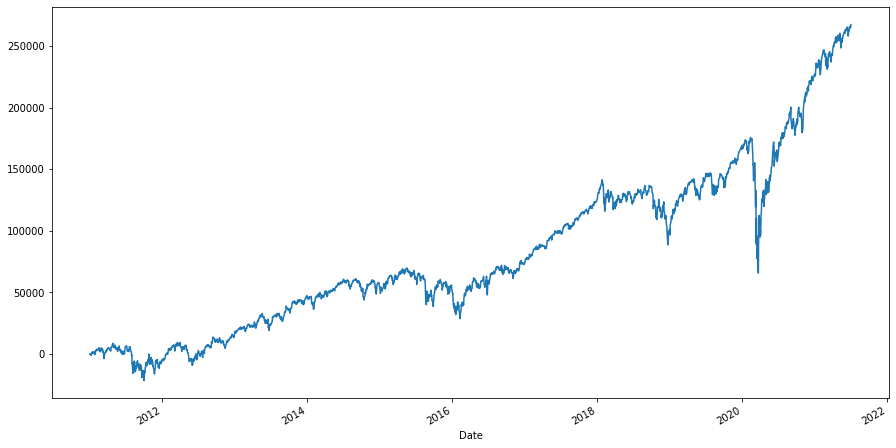

In [177]:
# Benchmark PnL
k = benchmark_ret
benchmark_pnl = pd.DataFrame()
benchmark_pnl['return'] = k
benchmark_pnl['capital'] = 100000
dates_to_split = pd.date_range(a.index[0], a.index[-1], freq='6M')
for i in range(len(dates_to_split)-1):
    benchmark_pnl.loc[dates_to_split[i]:dates_to_split[i+1],'capital'] = 100000+ (i+1)*10000
benchmark_pnl.loc[dates_to_split[len(dates_to_split)-1]:,'capital']=  100000+ len(dates_to_split)*10000
benchmark_pnl['PnL'] = benchmark_pnl['return']*benchmark_pnl['capital']
benchmark_pnl['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

In [178]:
dates_to_split

DatetimeIndex(['2011-01-31', '2011-07-31', '2012-01-31', '2012-07-31',
               '2013-01-31', '2013-07-31', '2014-01-31', '2014-07-31',
               '2015-01-31', '2015-07-31', '2016-01-31', '2016-07-31',
               '2017-01-31', '2017-07-31', '2018-01-31', '2018-07-31',
               '2019-01-31', '2019-07-31', '2020-01-31', '2020-07-31',
               '2021-01-31'],
              dtype='datetime64[ns]', freq='6M')

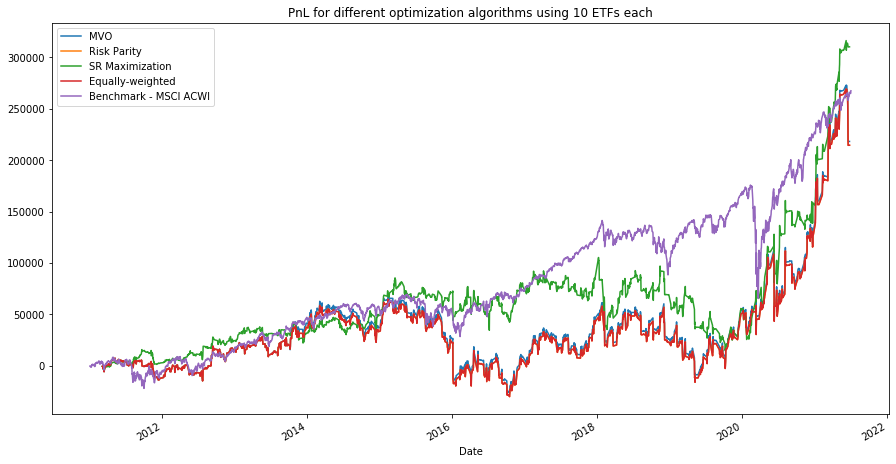

In [179]:
PnL_mvo.cumsum().plot(figsize=(15,8), label='MVO')
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
PnL_eq.cumsum().plot(figsize=(15,8), label='Equally-weighted')
benchmark_pnl['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('PnL for different optimization algorithms using 10 ETFs each')
plt.legend()
plt.show()

In [180]:
print(f'Max drawdown for MVO: {max_drawdown_mvo}')
overallrisk_mvo

Max drawdown for MVO: -292.98491020479054%


VaR 95%       VaR 99%      CVaR 95%      CVaR 99%
Period                                                        
1       -2218.107678  -2559.442937  -2388.775308  -2559.442937
2       -1087.632491  -1918.563347  -1503.097919  -1918.563347
3       -3016.335283  -5003.199794  -4009.767538  -5003.199794
4       -1252.972559  -1454.239244  -1353.605901  -1454.239244
5       -1747.793612  -2811.943159  -2279.868386  -2811.943159
...              ...           ...           ...           ...
120    -16974.713692 -16974.713692 -16974.713692 -16974.713692
121    -22882.098176 -29348.092042 -26115.095109 -29348.092042
122    -10297.779628 -16151.440443 -13224.610036 -16151.440443
123    -17865.720339 -25908.780954 -21887.250646 -25908.780954
124    -13529.329557 -25678.265510 -19603.797533 -25678.265510

[124 rows x 4 columns]

In [181]:
print(f'Max drawdown for Risk parity: {max_drawdown_rp}')
overallrisk_rp

Max drawdown for Risk parity: -294.4173203126006%


VaR 95%       VaR 99%      CVaR 95%      CVaR 99%
Period                                                        
1       -2218.107122  -2559.442484  -2388.774803  -2559.442484
2       -1087.632167  -1918.561345  -1503.096756  -1918.561345
3       -3016.331547  -5003.194703  -4009.763125  -5003.194703
4       -1252.971480  -1454.236842  -1353.604161  -1454.236842
5       -1747.791344  -2811.940187  -2279.865765  -2811.940187
...              ...           ...           ...           ...
120    -16929.915050 -16929.915050 -16929.915050 -16929.915050
121    -22822.183719 -29271.266046 -26046.724883 -29271.266046
122    -10271.089702 -16109.589279 -13190.339491 -16109.589279
123    -17819.889541 -25842.323210 -21831.106375 -25842.323210
124    -13494.904658 -25612.930503 -19553.917580 -25612.930503

[124 rows x 4 columns]

In [182]:
print(f'Max drawdown for SR maximization: {max_drawdown_sr}')
overallrisk_sr

Max drawdown for SR maximization: -711.7390739926797%


VaR 95%       VaR 99%      CVaR 95%      CVaR 99%
Period                                                        
1       -1625.380135  -2304.155466  -1964.767800  -2304.155466
2        -973.082744  -1517.894782  -1245.488763  -1517.894782
3       -2629.888615  -3499.897201  -3064.892908  -3499.897201
4        -273.903398   -342.622166   -308.262782   -342.622166
5       -1339.093970  -1476.933693  -1408.013832  -1476.933693
...              ...           ...           ...           ...
120    -13108.318836 -13108.318836 -13108.318836 -13108.318836
121    -14409.372937 -19614.774252 -17012.073594 -19614.774252
122     -4982.265231  -7590.473600  -6286.369415  -7590.473600
123    -13630.142195 -16997.781950 -15313.962072 -16997.781950
124    -10473.696970 -16036.033753 -13254.865362 -16036.033753

[124 rows x 4 columns]

In [183]:
print(f'Max drawdown for equally-weighted: {max_drawdown_eq}')
overallrisk_eq

Max drawdown for equally-weighted: -294.4180597374964%


VaR 95%       VaR 99%      CVaR 95%      CVaR 99%
Period                                                        
1       -2218.107678  -2559.442937  -2388.775308  -2559.442937
2       -1087.632491  -1918.563347  -1503.097919  -1918.563347
3       -3016.335283  -5003.199794  -4009.767538  -5003.199794
4       -1252.972559  -1454.239244  -1353.605901  -1454.239244
5       -1747.793612  -2811.943159  -2279.868386  -2811.943159
...              ...           ...           ...           ...
120    -16929.929228 -16929.929228 -16929.929228 -16929.929228
121    -22822.219110 -29271.292426 -26046.755768 -29271.292426
122    -10271.113802 -16109.616718 -13190.365260 -16109.616718
123    -17819.901177 -25842.334227 -21831.117702 -25842.334227
124    -13494.914793 -25612.947311 -19553.931052 -25612.947311

[124 rows x 4 columns]

Text(0.5, 1.0, 'Dollar value for each ETF for MVO using 10 ETFs each')

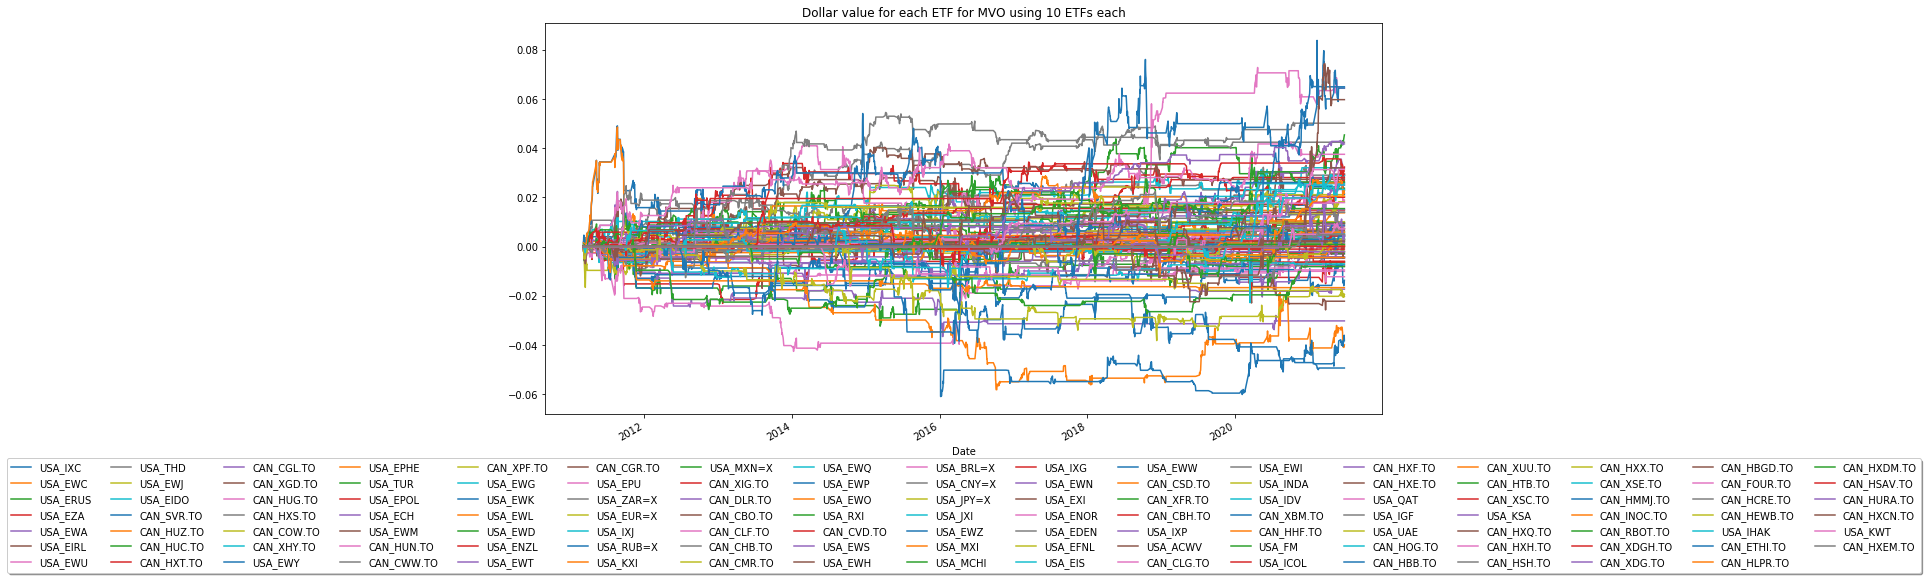

In [184]:
dollar_full_portfolio_mvo.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_mvo.columns)/7))
plt.title('Dollar value for each ETF for MVO using 10 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for Risk parity using 10 ETFs each')

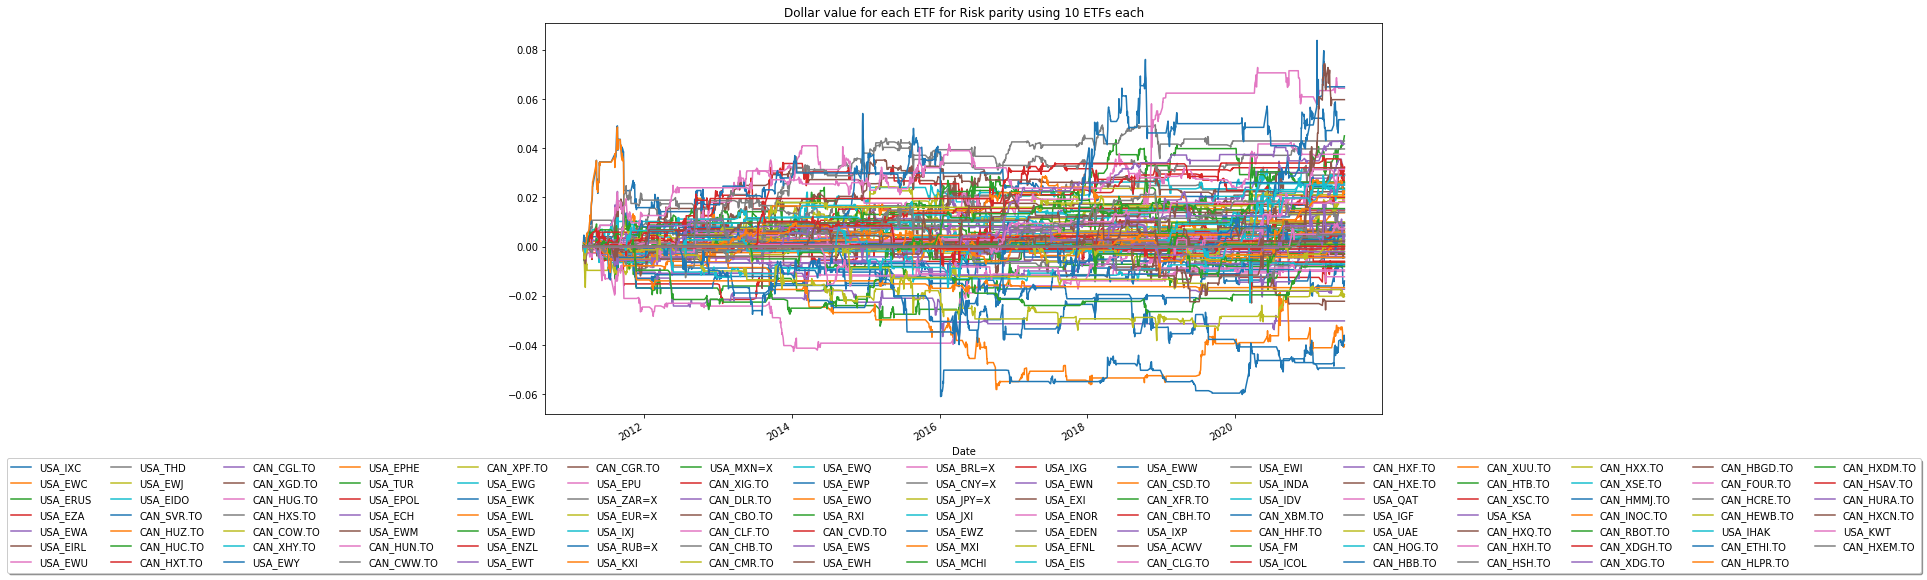

In [185]:
dollar_full_portfolio_rp.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_rp.columns)/7))
plt.title('Dollar value for each ETF for Risk parity using 10 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for SR maximization using 10 ETFs each')

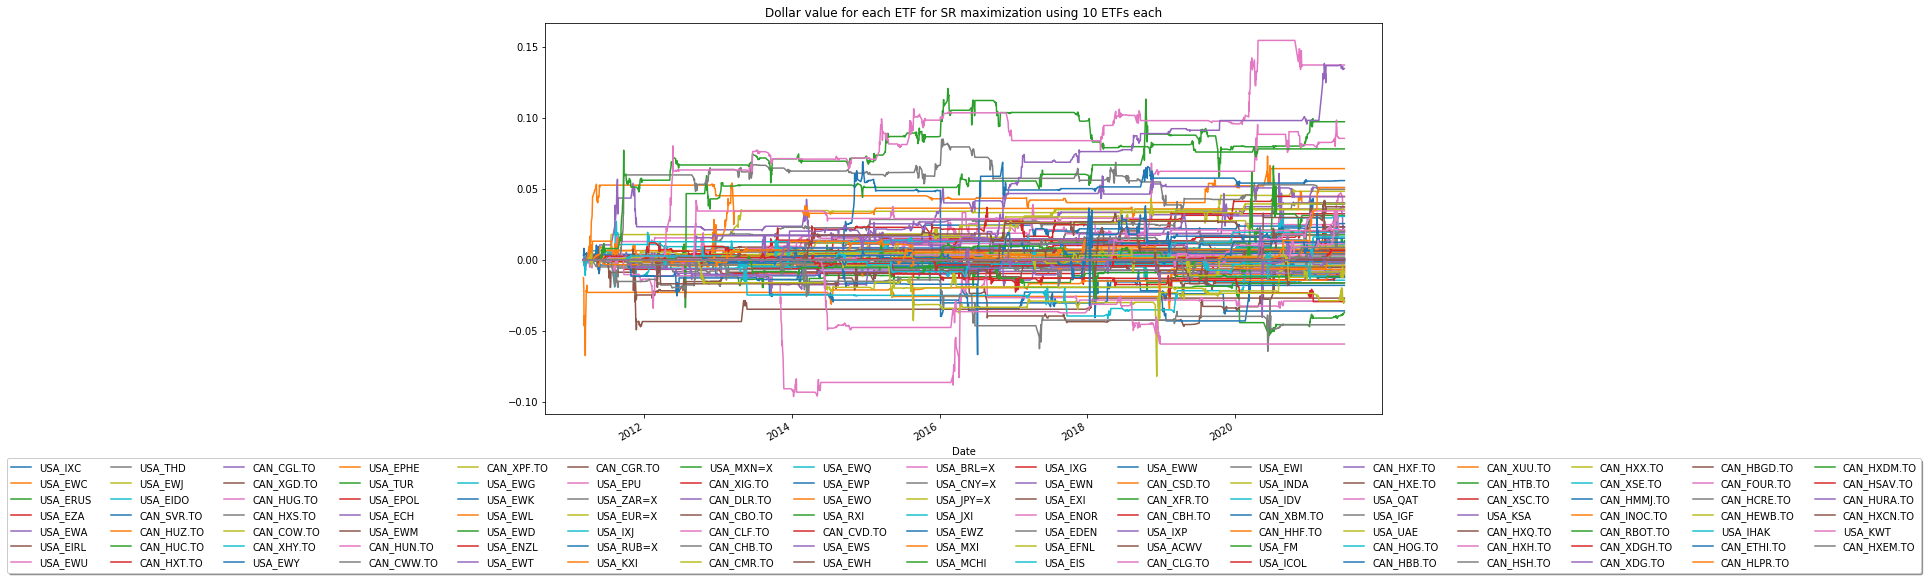

In [186]:
dollar_full_portfolio_sr.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_sr.columns)/7))
plt.title('Dollar value for each ETF for SR maximization using 10 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for equally-weighted using 10 ETFs each')

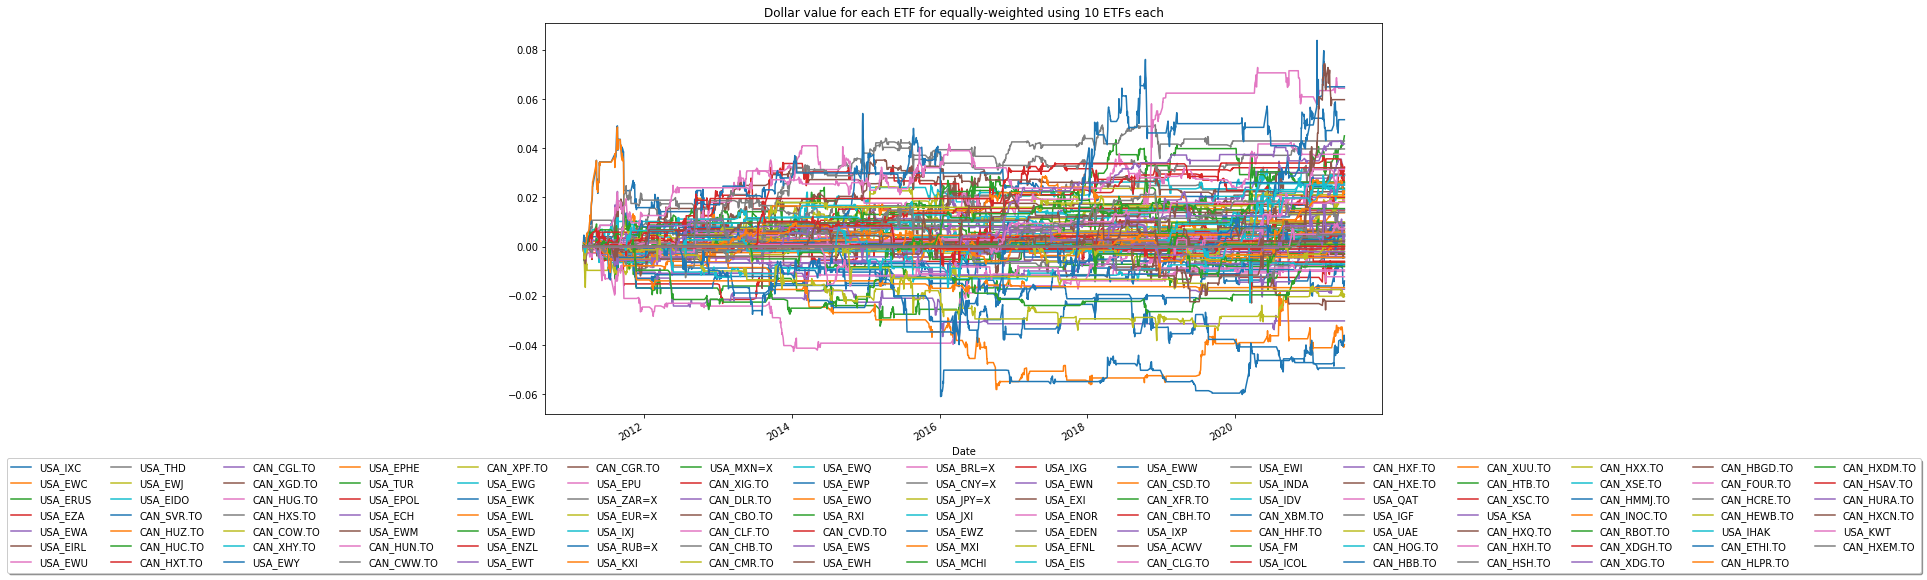

In [187]:
dollar_full_portfolio_eq.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_eq.columns)/7))
plt.title('Dollar value for each ETF for equally-weighted using 10 ETFs each')

15 cutoff ETFs

In [188]:
opt15 = portfolio_optimizer(semiannual)
# MVO:
dollar_full_portfolio_mvo, PnL_mvo,usdrisk_mvo,cadrisk_mvo,overallrisk_mvo, max_drawdown_mvo,sharpe_mvo,_finalweights_mvo = opt15.portfolio_simulator(100000, riskfree, top15, 15, VaRcutoff, 'MVO', benchmark_excess)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt15.portfolio_simulator(100000, riskfree, top15, 15, VaRcutoff, 'Risk parity')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr = opt15.portfolio_simulator(100000, riskfree, top15, 15, VaRcutoff, 'Sharpe ratio maximization')
# equally-weighted
dollar_full_portfolio_eq, PnL_eq,usdrisk_eq,cadrisk_eq,overallrisk_eq, max_drawdown_eq,sharpe_eq,_finalweights_eq = opt10.portfolio_simulator(100000, riskfree, top15, 15, VaRcutoff, 'Equally weighted')

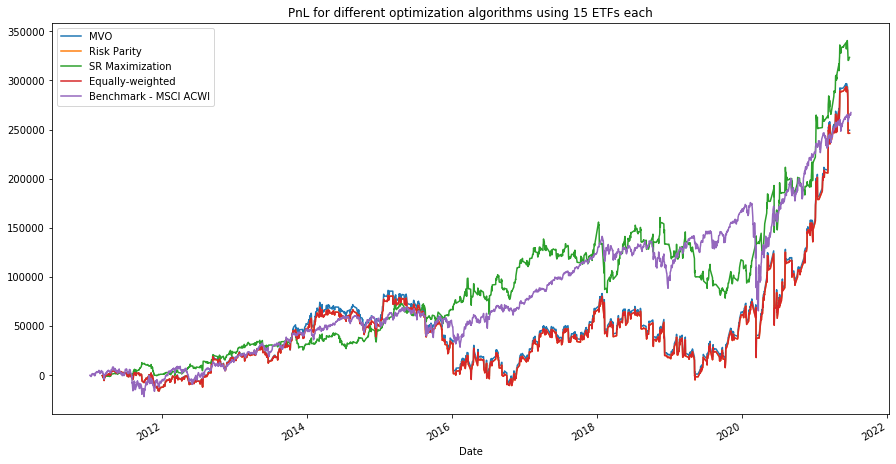

In [189]:
PnL_mvo.cumsum().plot(figsize=(15,8), label='MVO')
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
PnL_eq.cumsum().plot(figsize=(15,8), label='Equally-weighted')
benchmark_pnl['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('PnL for different optimization algorithms using 15 ETFs each')
plt.legend()
plt.show()

In [190]:
PnL_sr.cumsum()

Date
2011-03-07      -658.385954
2011-03-08      -879.163902
2011-03-09     -1103.161761
2011-03-10     -2570.467034
2011-03-11     -2210.574605
                  ...      
2021-06-21    320894.514735
2021-06-22    321952.362042
2021-06-23    322617.267444
2021-06-24    323165.587316
2021-06-25    323532.700133
Length: 1895, dtype: float64

In [191]:
print(f'Max drawdown for MVO: {max_drawdown_mvo}')
overallrisk_mvo

Max drawdown for MVO: -386.25433152289907%


VaR 95%       VaR 99%      CVaR 95%      CVaR 99%
Period                                                        
1       -2039.787764  -2271.900626  -2155.844195  -2271.900626
2        -994.854342  -1801.483890  -1398.169116  -1801.483890
3       -2298.893533  -3820.912514  -3059.903024  -3820.912514
4       -1272.873992  -1408.929018  -1340.901505  -1408.929018
5       -1605.731908  -2881.408212  -2243.570060  -2881.408212
...              ...           ...           ...           ...
120    -18629.166972 -18629.166972 -18629.166972 -18629.166972
121    -20173.285897 -23331.367358 -21752.326627 -23331.367358
122    -11795.512895 -15872.792539 -13834.152717 -15872.792539
123    -16584.965443 -22020.852758 -19302.909100 -22020.852758
124    -12706.067964 -22653.361432 -17679.714698 -22653.361432

[124 rows x 4 columns]

In [192]:
print(f'Max drawdown for Risk parity: {max_drawdown_rp}')
overallrisk_rp

Max drawdown for Risk parity: -386.25314036654026%


VaR 95%       VaR 99%      CVaR 95%      CVaR 99%
Period                                                        
1       -2039.787169  -2271.899911  -2155.843540  -2271.899911
2        -994.853695  -1801.482635  -1398.168165  -1801.482635
3       -2298.890175  -3820.907480  -3059.898827  -3820.907480
4       -1272.872859  -1408.926908  -1340.899883  -1408.926908
5       -1605.729310  -2881.405049  -2243.567180  -2881.405049
...              ...           ...           ...           ...
120    -18603.521972 -18603.521972 -18603.521972 -18603.521972
121    -20145.621381 -23299.468454 -21722.544917 -23299.468454
122    -11779.513988 -15851.269995 -13815.391991 -15851.269995
123    -16562.716624 -21991.308799 -19277.012712 -21991.308799
124    -12689.156622 -22623.199643 -17656.178132 -22623.199643

[124 rows x 4 columns]

In [193]:
print(f'Max drawdown for SR maximization: {max_drawdown_sr}')
overallrisk_sr

Max drawdown for SR maximization: -144.33072354347618%


VaR 95%       VaR 99%      CVaR 95%      CVaR 99%
Period                                                        
1       -1003.182877  -1650.852757  -1327.017817  -1650.852757
2        -777.547130  -1166.292654   -971.919892  -1166.292654
3        -839.080843  -1726.215683  -1282.648263  -1726.215683
4        -271.732781   -337.665025   -304.698903   -337.665025
5       -1320.035319  -1454.614319  -1387.324819  -1454.614319
...              ...           ...           ...           ...
120    -13031.100763 -13031.100763 -13031.100763 -13031.100763
121    -10271.422633 -15375.312221 -12823.367427 -15375.312221
122     -4511.245357  -7050.164477  -5780.704917  -7050.164477
123    -11200.315236 -14619.276915 -12909.796076 -14619.276915
124     -6772.194326  -7893.698361  -7332.946343  -7893.698361

[124 rows x 4 columns]

In [194]:
print(f'Max drawdown for equally-weighted: {max_drawdown_eq}')
overallrisk_eq

Max drawdown for equally-weighted: -386.25433152289907%


VaR 95%       VaR 99%      CVaR 95%      CVaR 99%
Period                                                        
1       -2039.787764  -2271.900626  -2155.844195  -2271.900626
2        -994.854342  -1801.483890  -1398.169116  -1801.483890
3       -2298.893533  -3820.912514  -3059.903024  -3820.912514
4       -1272.873992  -1408.929018  -1340.901505  -1408.929018
5       -1605.731908  -2881.408212  -2243.570060  -2881.408212
...              ...           ...           ...           ...
120    -18603.547473 -18603.547473 -18603.547473 -18603.547473
121    -20145.758319 -23299.530401 -21722.644360 -23299.530401
122    -11779.541213 -15851.300028 -13815.420620 -15851.300028
123    -16562.729880 -21991.329269 -19277.029575 -21991.329269
124    -12689.166113 -22623.227504 -17656.196809 -22623.227504

[124 rows x 4 columns]

Text(0.5, 1.0, 'Dollar value for each ETF for MVO using 15 ETFs each')

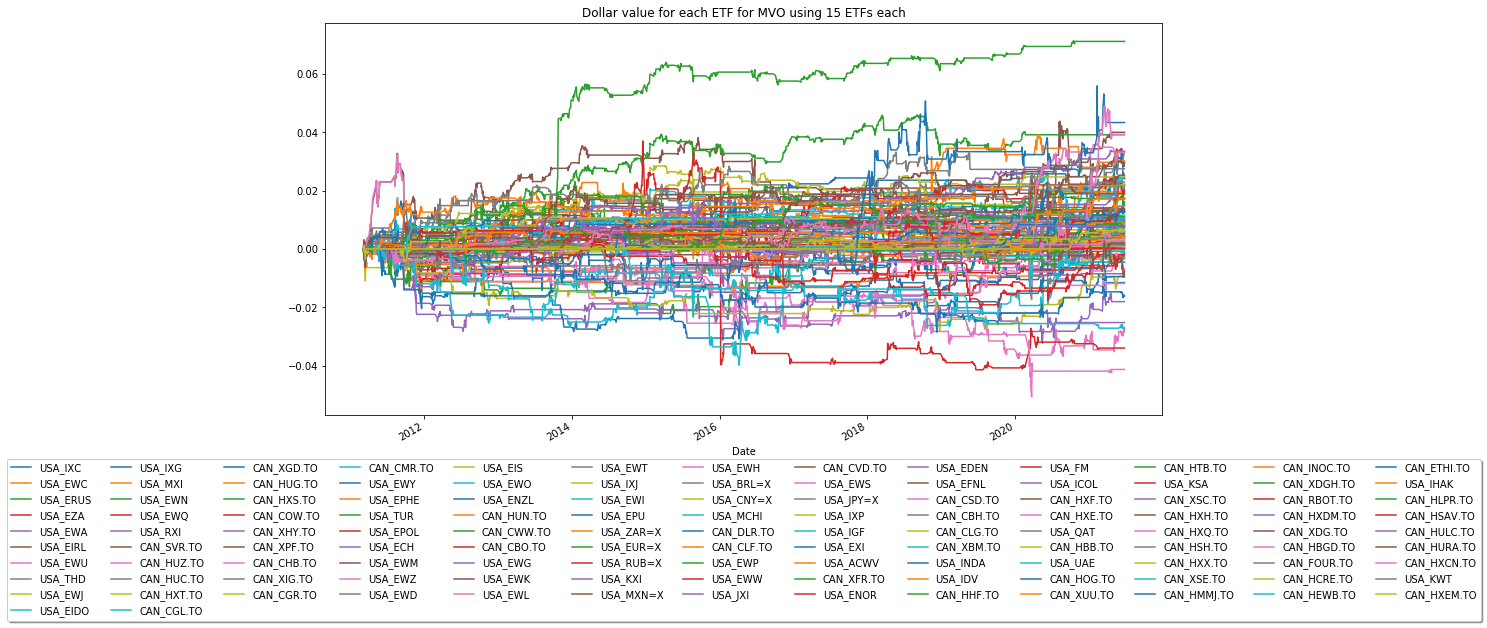

In [195]:
dollar_full_portfolio_mvo.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_mvo.columns)/9))
plt.title('Dollar value for each ETF for MVO using 15 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for Risk parity using 15 ETFs each')

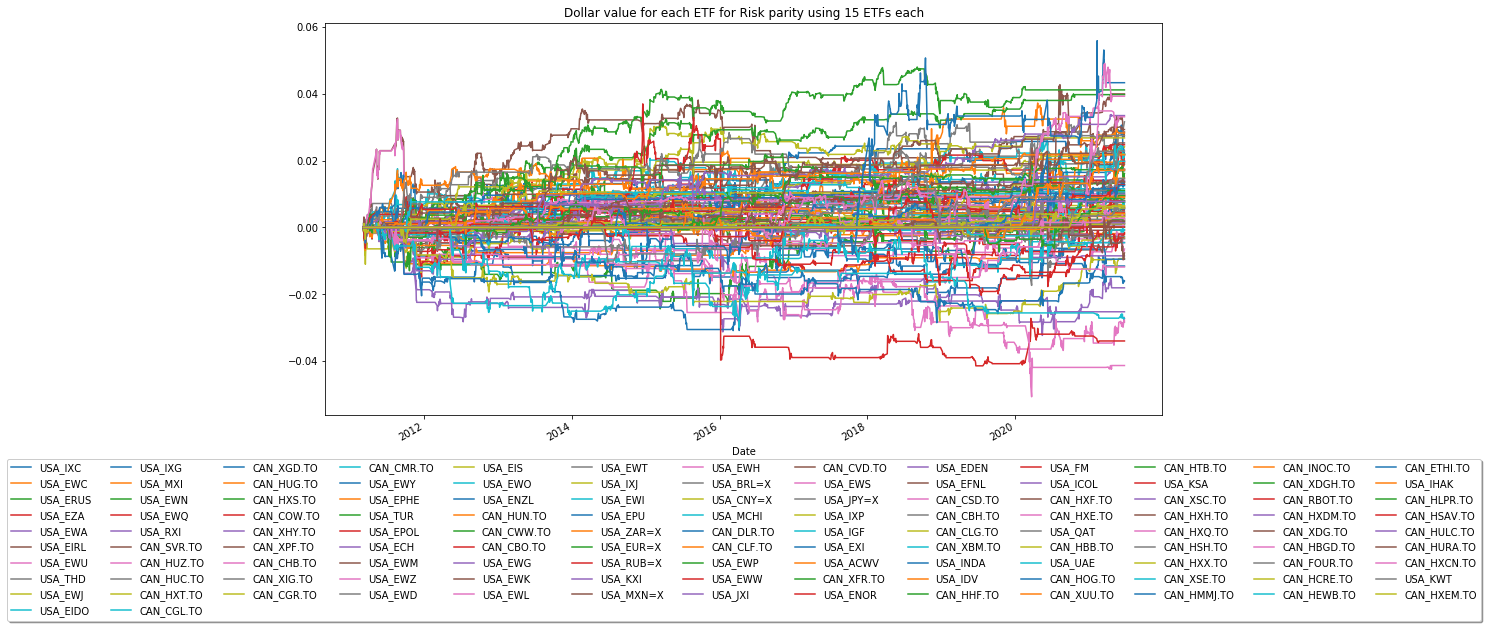

In [196]:
dollar_full_portfolio_rp.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_rp.columns)/9))
plt.title('Dollar value for each ETF for Risk parity using 15 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for SR maximization using 15 ETFs each')

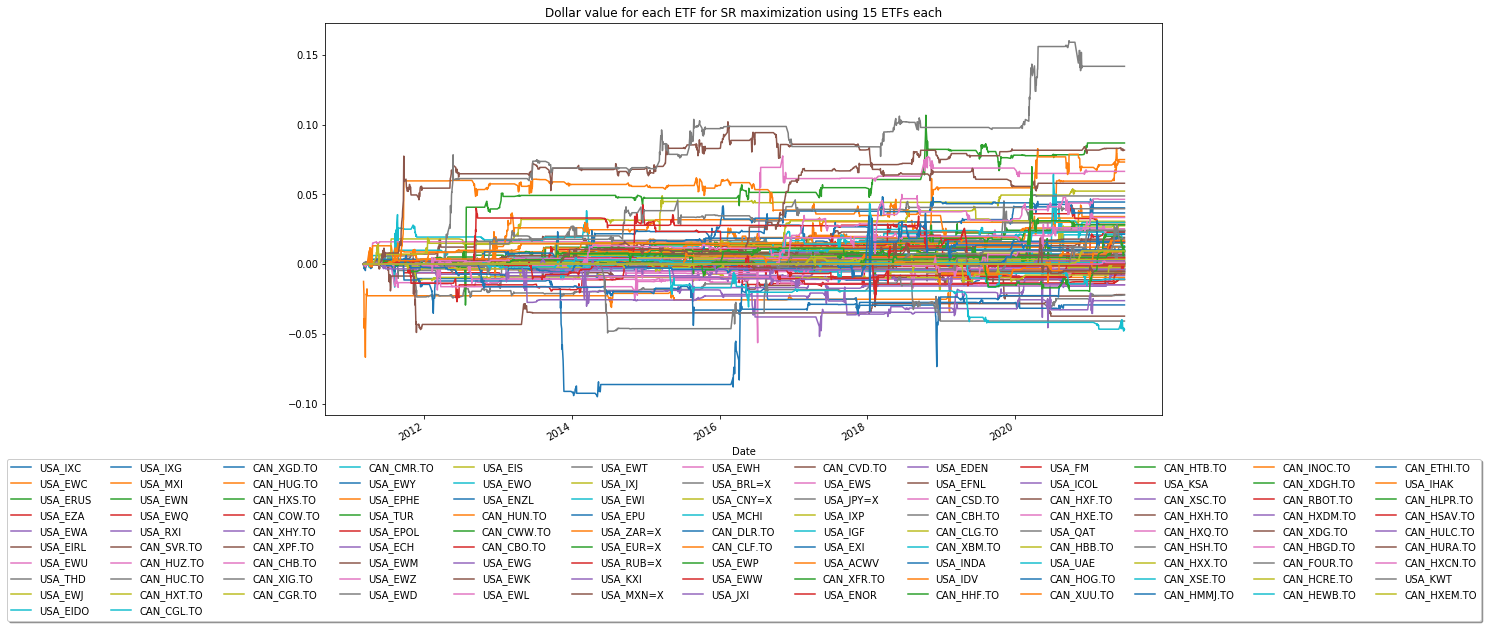

In [197]:
dollar_full_portfolio_sr.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_sr.columns)/9))
plt.title('Dollar value for each ETF for SR maximization using 15 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for equally-weighted using 15 ETFs each')

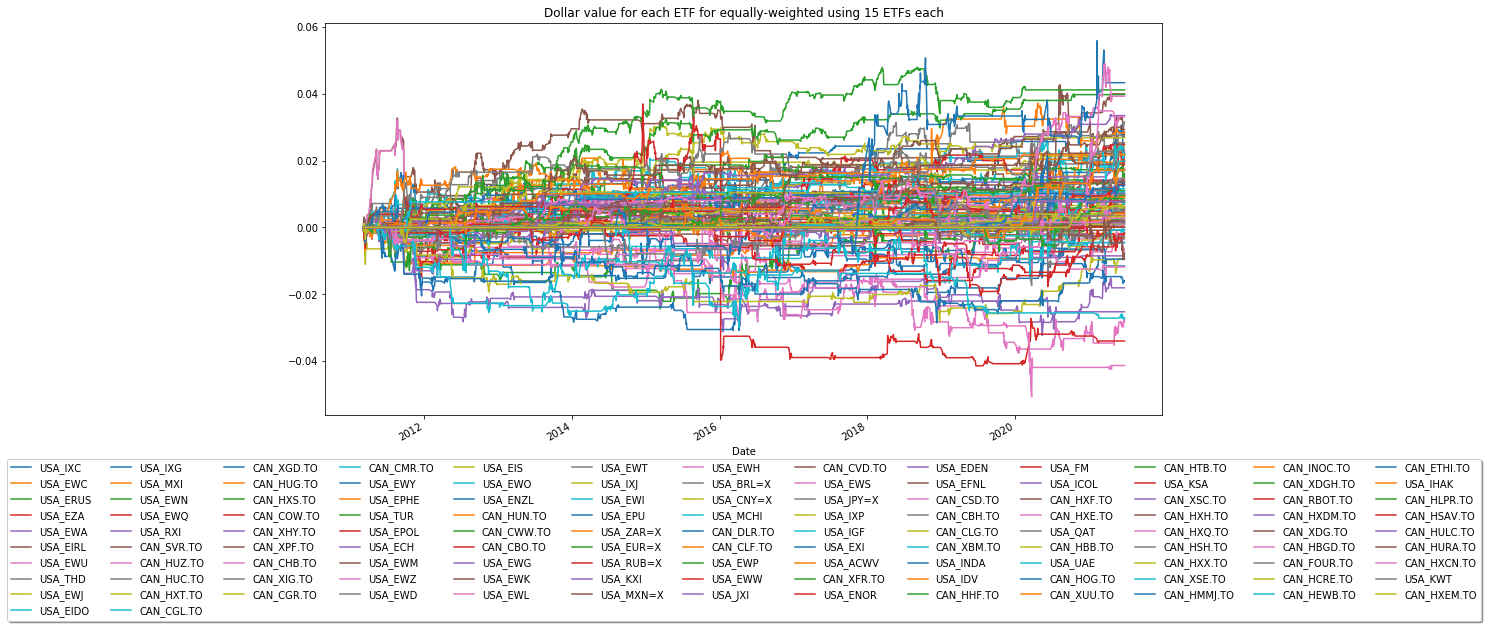

In [198]:
dollar_full_portfolio_eq.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_eq.columns)/9))
plt.title('Dollar value for each ETF for equally-weighted using 15 ETFs each')

30 cutoff ETFs

In [199]:
opt30 = portfolio_optimizer(semiannual)

# MVO:
dollar_full_portfolio_mvo, PnL_mvo,usdrisk_mvo,cadrisk_mvo,overallrisk_mvo, max_drawdown_mvo,sharpe_mvo,_finalweights_mvo = opt30.portfolio_simulator(100000, riskfree, top30, 30,VaRcutoff, 'MVO', benchmark_excess)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt30.portfolio_simulator(100000, riskfree, top30, 30,VaRcutoff, 'Risk parity')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr = opt30.portfolio_simulator(100000, riskfree, top30, 30,VaRcutoff, 'Sharpe ratio maximization')
# equally-weighted
dollar_full_portfolio_eq, PnL_eq,usdrisk_eq,cadrisk_eq,overallrisk_eq, max_drawdown_eq,sharpe_eq,_finalweights_eq = opt10.portfolio_simulator(100000, riskfree, top30, 30, VaRcutoff, 'Equally weighted')

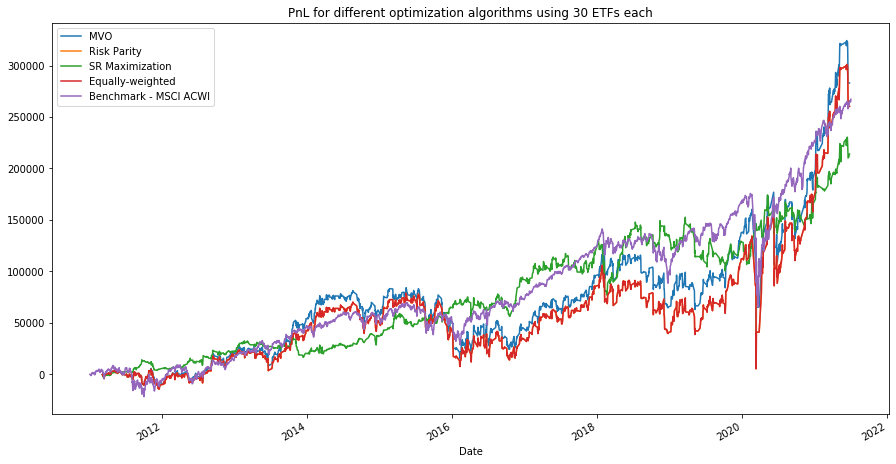

In [200]:
PnL_mvo.cumsum().plot(figsize=(15,8), label='MVO')
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
PnL_eq.cumsum().plot(figsize=(15,8), label='Equally-weighted')
benchmark_pnl['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('PnL for different optimization algorithms using 30 ETFs each')
plt.legend()
plt.show()

In [201]:
print(f'Max drawdown for MVO: {max_drawdown_mvo}')
overallrisk_mvo

Max drawdown for MVO: -366.67893681433964%


VaR 95%       VaR 99%      CVaR 95%      CVaR 99%
Period                                                        
1       -1603.354987  -1928.034507  -1765.694747  -1928.034507
2        -808.356424  -1497.318347  -1152.837385  -1497.318347
3       -1741.713992  -2634.792306  -2188.253149  -2634.792306
4       -1435.729837  -1666.823780  -1551.276808  -1666.823780
5       -1435.452445  -2293.285365  -1864.368905  -2293.285365
...              ...           ...           ...           ...
120    -16048.713126 -16048.713126 -16048.713126 -16048.713126
121    -16976.774810 -19257.361452 -18117.068131 -19257.361452
122     -9301.664365 -12163.047693 -10732.356029 -12163.047693
123    -14384.158455 -20620.438829 -17502.298642 -20620.438829
124    -11678.201094 -19266.581681 -15472.391387 -19266.581681

[124 rows x 4 columns]

In [202]:
print(f'Max drawdown for Risk parity: {max_drawdown_rp}')
overallrisk_rp

Max drawdown for Risk parity: -402.2344873570039%


VaR 95%       VaR 99%      CVaR 95%      CVaR 99%
Period                                                        
1       -1603.353974  -1928.033206  -1765.693590  -1928.033206
2        -808.355470  -1497.316493  -1152.835981  -1497.316493
3       -1741.711299  -2634.788224  -2188.249762  -2634.788224
4       -1435.723137  -1666.816236  -1551.269686  -1666.816236
5       -1435.452085  -2293.276665  -1864.364375  -2293.276665
...              ...           ...           ...           ...
120    -15844.040658 -15844.040658 -15844.040658 -15844.040658
121    -16761.879598 -19013.560437 -17887.720017 -19013.560437
122     -9184.801043 -12010.236554 -10597.518799 -12010.236554
123    -14205.047188 -20363.677163 -17284.362175 -20363.677163
124    -11533.886706 -19028.491528 -15281.189117 -19028.491528

[124 rows x 4 columns]

In [203]:
print(f'Max drawdown for SR maximization: {max_drawdown_sr}')
overallrisk_sr

Max drawdown for SR maximization: -74.022968446774%


VaR 95%       VaR 99%      CVaR 95%      CVaR 99%
Period                                                       
1      -1001.062068  -1646.373101  -1323.717585  -1646.373101
2       -779.323594  -1167.709963   -973.516779  -1167.709963
3       -853.715906  -1634.840991  -1244.278448  -1634.840991
4       -270.393849   -331.788091   -301.090970   -331.788091
5       -306.667618   -550.294480   -428.481049   -550.294480
...             ...           ...           ...           ...
120    -5338.787367  -5338.787367  -5338.787367  -5338.787367
121    -6919.334084  -8987.205991  -7953.270038  -8987.205991
122    -3350.786503  -4354.541975  -3852.664239  -4354.541975
123    -7328.849077 -13299.526110 -10314.187594 -13299.526110
124    -6341.276378  -7432.218427  -6886.747402  -7432.218427

[124 rows x 4 columns]

In [204]:
print(f'Max drawdown for equally-weighted: {max_drawdown_eq}')
overallrisk_eq

Max drawdown for equally-weighted: -402.24211558329097%


VaR 95%       VaR 99%      CVaR 95%      CVaR 99%
Period                                                        
1       -1603.354987  -1928.034507  -1765.694747  -1928.034507
2        -808.356424  -1497.318347  -1152.837385  -1497.318347
3       -1741.713992  -2634.792306  -2188.253149  -2634.792306
4       -1435.729837  -1666.823780  -1551.276808  -1666.823780
5       -1435.452445  -2293.285365  -1864.368905  -2293.285365
...              ...           ...           ...           ...
120    -15844.096651 -15844.096651 -15844.096651 -15844.096651
121    -16761.967809 -19013.698206 -17887.833007 -19013.698206
122     -9184.840247 -12010.286072 -10597.563159 -12010.286072
123    -14205.078360 -20363.718204 -17284.398282 -20363.718204
124    -11533.916253 -19028.541965 -15281.229109 -19028.541965

[124 rows x 4 columns]

Text(0.5, 1.0, 'Dollar value for each ETF for MVO using 30 ETFs each')

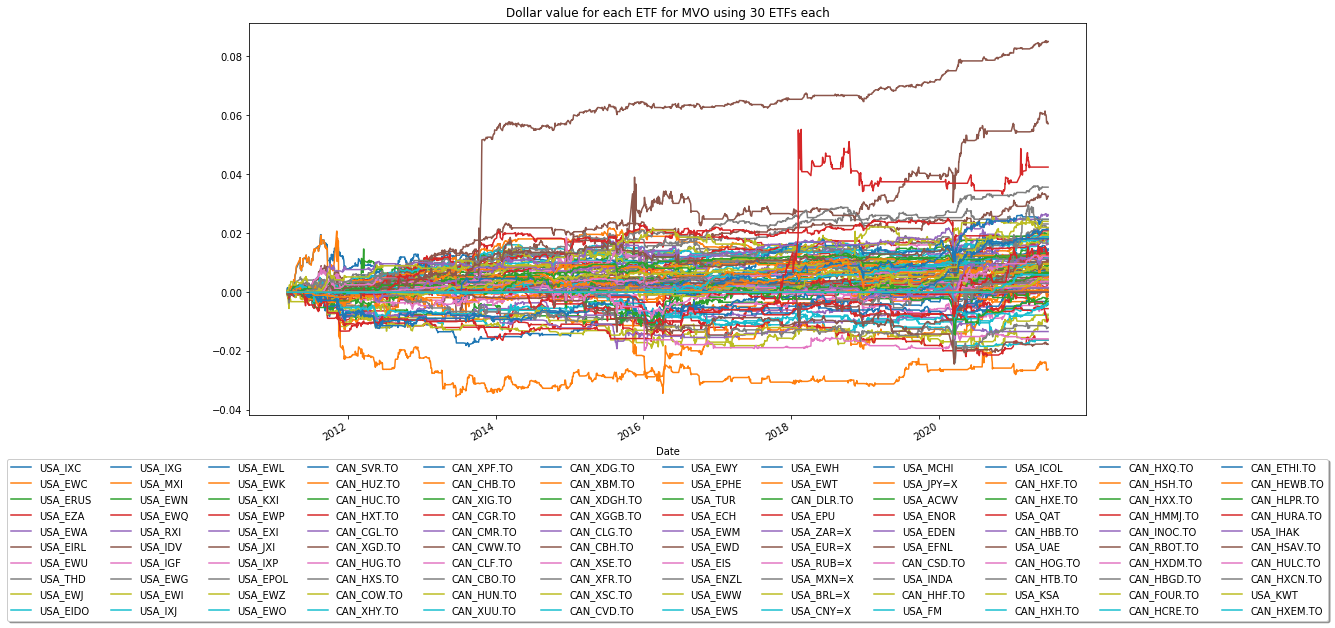

In [205]:
dollar_full_portfolio_mvo.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_mvo.columns)/10))
plt.title('Dollar value for each ETF for MVO using 30 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for Risk parity using 30 ETFs each')

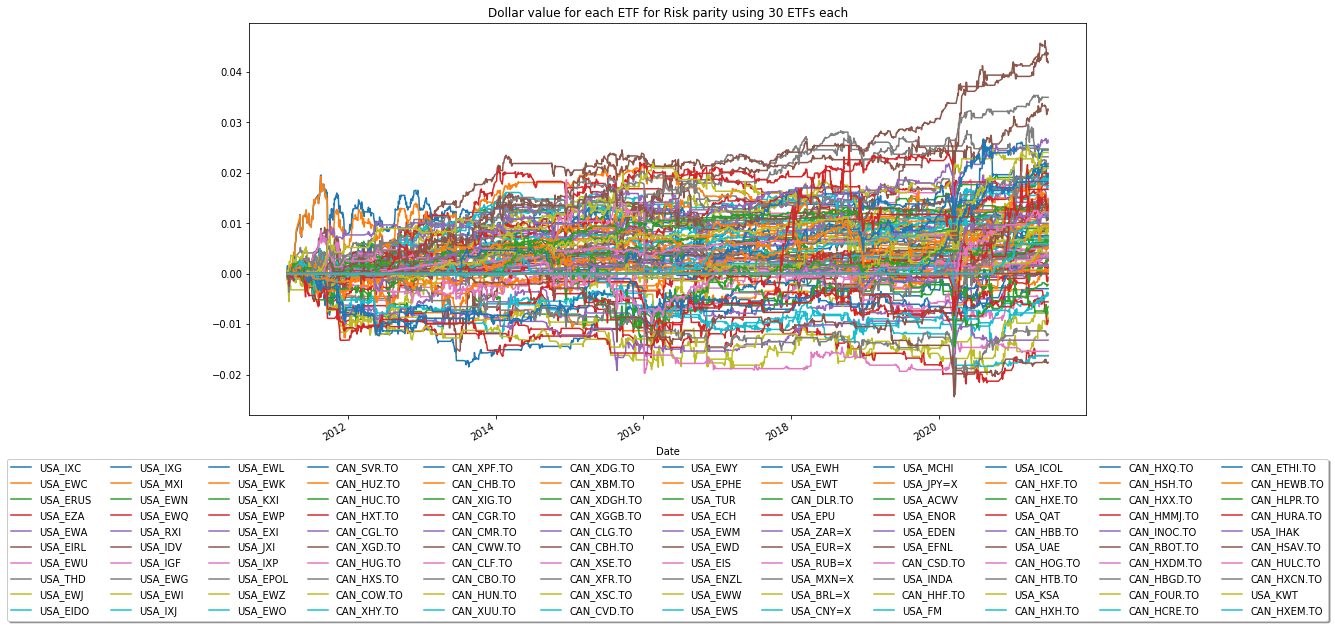

In [206]:
dollar_full_portfolio_rp.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_rp.columns)/10))
plt.title('Dollar value for each ETF for Risk parity using 30 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for SR maximization using 30 ETFs each')

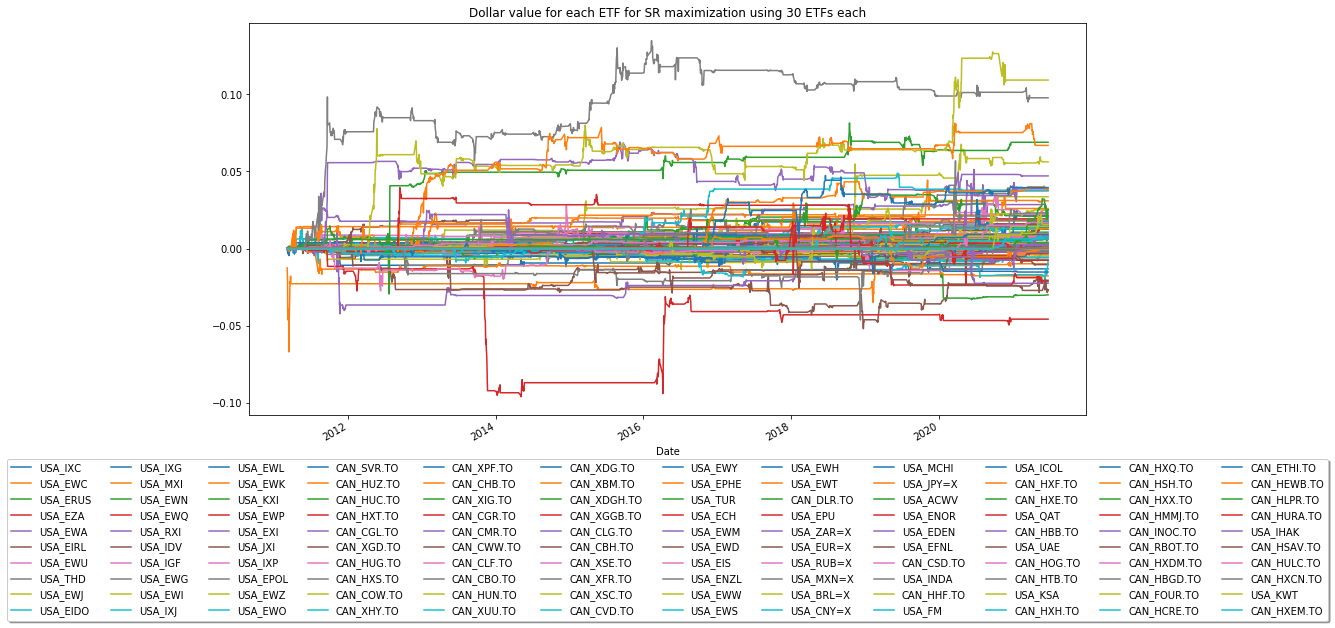

In [207]:
dollar_full_portfolio_sr.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_sr.columns)/10))
plt.title('Dollar value for each ETF for SR maximization using 30 ETFs each')

Text(0.5, 1.0, 'Dollar value for each ETF for equally-weighted using 30 ETFs each')

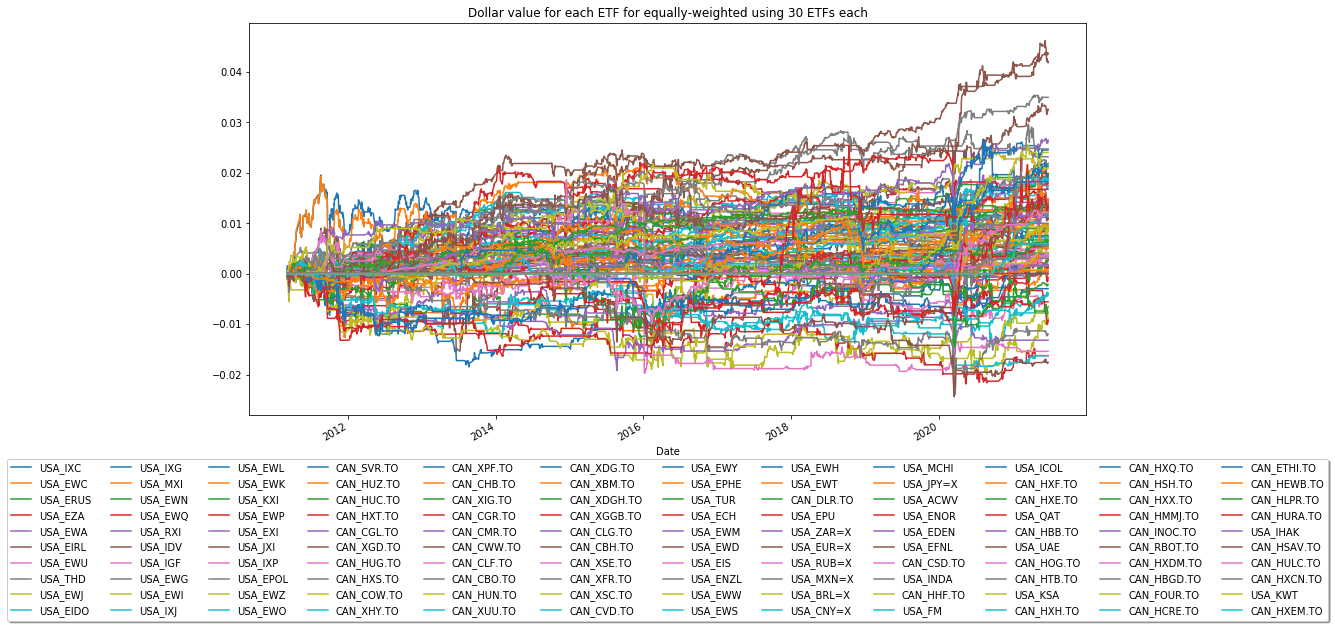

In [208]:
dollar_full_portfolio_eq.cumsum().plot(figsize = (15,8))
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), 
           fancybox=True, shadow=True, ncol=round(len(dollar_full_portfolio_eq.columns)/10))
plt.title('Dollar value for each ETF for equally-weighted using 30 ETFs each')

# Scenario Analysis

We will pick time period 2012 January to 2017 December as the scenario testing period, two scenarios will be tested:
1. the entire market will crash by 0.5% with probability 2% in a single day;
2. each ETFs will randomly crash by a half with probability 5% in a single day.

In [209]:
# extract rets from 2020.1 to 2017.12
periodic_rets = {}
for i in range(0,14):
    periodic_rets[i] = semiannual[i]

In [210]:
# Market crush scenario
opt_sa1 = portfolio_optimizer(periodic_rets)

# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp = opt_sa1.portfolio_simulator(100000, riskfree, top15, 15, VaRcutoff, 'Risk parity', scenario='Market crash')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr = opt_sa1.portfolio_simulator(100000, riskfree, top15, 15, VaRcutoff, 'Sharpe ratio maximization', scenario='Market crash')

ValueError: too many values to unpack (expected 6)

In [ ]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')

plt.title('PnL of 15 ETFs under 2% probability of market 0.5% crush')
plt.legend()
plt.show()

In [ ]:
print(f'Max drawdown for Risk parity: {max_drawdown_rp}')
overallrisk_rp

In [ ]:
overallrisk_rp.sum(axis=1)

In [ ]:
print(f'Max drawdown for Risk parity: {max_drawdown_sr}')
overallrisk_sr

In [ ]:
# Individual ETF random crush scenario
opt_sa2 = portfolio_optimizer(periodic_rets)

# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp = opt_sa2.portfolio_simulator(100000, riskfree, top15, 15, VaRcutoff, 'Risk parity', scenario='Random ETF crash')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr = opt_sa2.portfolio_simulator(100000, riskfree, top15, 15, VaRcutoff, 'Sharpe ratio maximization', scenario='Random ETF crash')


In [ ]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')

plt.title('PnL of 15 ETFs under 5% probability of half crush of each ETF')
plt.legend()
plt.show()

In [ ]:
print(f'Max drawdown for Risk parity: {max_drawdown_rp}')
overallrisk_rp

In [ ]:
print(f'Max drawdown for Risk parity: {max_drawdown_sr}')
overallrisk_sr

In [ ]:
# Market crush scenario
opt_sa1 = portfolio_optimizer(periodic_rets)

# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp = opt_sa1.portfolio_simulator(100000, riskfree, top15, 15, VaRcutoff, 'Risk parity', scenario='MV ETF crash')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr = opt_sa1.portfolio_simulator(100000, riskfree, top15, 15, VaRcutoff, 'Sharpe ratio maximization', scenario='MV ETF crash')

In [ ]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')

plt.title('PnL of 15 ETFs under 5% probability of mv crush of each ETF')
plt.legend()
plt.show()

In [ ]:
print(f'Max drawdown for Risk parity: {max_drawdown_rp}')
overallrisk_rp

In [ ]:
print(f'Max drawdown for Risk parity: {max_drawdown_sr}')
overallrisk_sr